In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import traceback

import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Input, Dense, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras            import backend as K
from tensorflow.keras.callbacks  import EarlyStopping

from scipy.ndimage import sobel

In [2]:
def make_model():
    
    inputs   = Input(shape=(2,))
    
    f_sin    = Lambda(lambda x : K.sin(x))(inputs)
    f_sq     = Lambda(lambda x : K.square(x))(inputs)
    f_corr   = Lambda(lambda x : K.prod(x, axis=-1, keepdims=True))(inputs)
    features = Concatenate()([inputs, f_sin, f_sq, f_corr])
    
    x        = Dense(10, activation='relu'   )(features) 
    outputs  = Dense(1,  activation='sigmoid')(x) 
    
    model    = Model(inputs=inputs, outputs=outputs)
    return model

def sample_normal(shape, mu, sig):
    return (np.random.normal(size=shape) * sig) + mu    

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

<IPython.core.display.Javascript object>


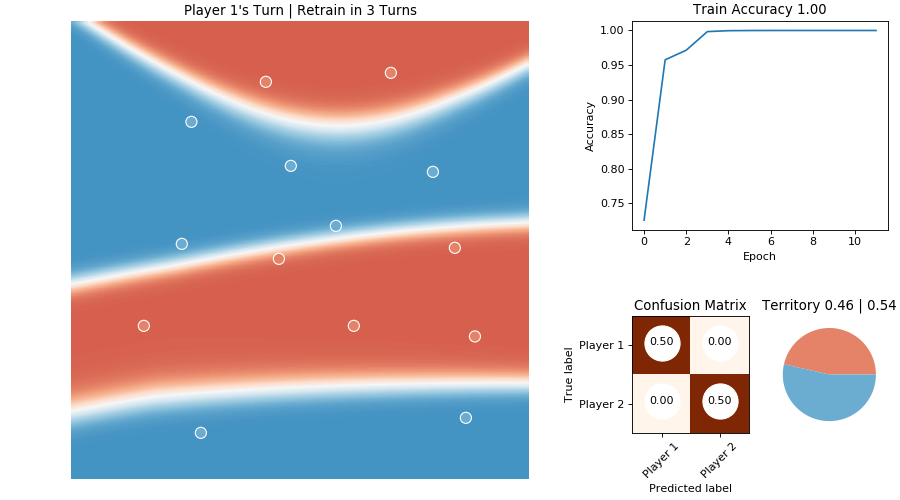

In [5]:
model = make_model()
model.compile(Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])

num_players = 2
players     = [[],[]]

game_round  = 0
game_turn   = 0
game_player = 0

res    = 100
xs     = np.linspace(-1,1,res)
ys     = np.linspace(-1,1,res)
xv, yv = np.meshgrid(xs, ys)
xv     = np.reshape(xv, (-1,))
yv     = np.reshape(yv, (-1,))
grid   = np.stack([xv,yv], axis=-1)
grid_preds = np.ones((res,res)) * 0.5
cm = np.zeros((2,2), dtype=np.float32)
loss, acc = 0, [0]

retrain = False

figw, figh, figdpi = 900, 500, 80
fig = plt.figure(num='Regionnaires', facecolor='white', figsize=(figw/figdpi, figh/figdpi), dpi=figdpi, constrained_layout=True)

gs = fig.add_gridspec(2, 6)

fig.add_subplot(gs[:,:-2])
ax_board= fig.gca()
plt.title('Player %d : Place a piece...' % (game_player+1))
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.axis('off')
plt.axis('equal')
plt.imshow(grid_preds, extent=(-1,1,1,-1), vmin=0, vmax=1, interpolation='bilinear', cmap=plt.get_cmap('RdBu'))

fig.add_subplot(gs[:1, -2:])
ax_train = fig.gca()
def plot_train(acc):
    plt.title('Train Accuracy %.2f' % (acc[-1]))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(list(range(len(acc))), acc)
plot_train(acc)

fig.add_subplot(gs[1:, -2:-1])
ax_conf = fig.gca()
def plot_confusion(cm):
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Oranges'))
    classes = ['Player 1', 'Player 2']
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.scatter(j, i-0.05, s=1000, c='w')
            plt.text(j, i, format(cm[i, j], '0.2f'), horizontalalignment='center', color='black')
plot_confusion(cm)

player_colours = plt.get_cmap('RdBu')
player_colours = np.array([player_colours(64), player_colours(255-64)])

fig.add_subplot(gs[1:, -1:])
ax_pie = fig.gca()
def plot_pie(a0,a1, player_colours):
    plt.title('Territory %.2f | %.2f' % (a0, a1))
    cmap = plt.get_cmap('tab10')
    plt.pie([a0,a1], colors=player_colours)
plot_pie(0.5, 0.5, player_colours)

def onclick(event):
    try:
        global player_colours, cm, loss, acc, retrain, model, grid, grid_preds
        global game_round, game_turn, game_player, num_players, players
        
        num_points_per_round = 2
        samples_per_point    = 1000
        variance             = 0.01
        
        if not (ax_board == event.inaxes) or (event.xdata is None) or (event.ydata is None):
            return
        if (event.xdata < -1) or (event.xdata > 1) or (event.ydata < -1) or (event.ydata > 1):
            return

        new_point = np.array([event.xdata, event.ydata])
        
        players[game_player] += [new_point]

        if (retrain):

            game_round += 1

            sample_points = []
            sample_labels = []
            for player_id in range(num_players):
                for point in players[player_id]:
                    sample_points += [sample_normal((samples_per_point, 2), point, np.array([[variance, variance]]))]
                sample_labels += [np.ones((len(players[player_id])*samples_per_point,), dtype=np.int32) * player_id]
            sample_points = np.concatenate(sample_points, axis=0)
            sample_labels = np.concatenate(sample_labels, axis=0)

            reset_weights(model)
            
            halting = EarlyStopping(monitor='binary_accuracy', min_delta=0, patience=5, verbose=0, mode='max')
            
            h = model.fit(x=sample_points, y=sample_labels, batch_size=32, epochs=100, callbacks=[halting])
            loss, acc = h.history['loss'][-1], h.history['binary_accuracy']
            
            grid_preds = model.predict(grid)
            grid_preds = np.reshape(grid_preds, (res, res))
            
            sample_points = []
            sample_labels = []
            for player_id in range(num_players):
                for point in players[player_id]:
                    sample_points += [point] 
                sample_labels += [player_id] * len(players[player_id])
            sample_points = np.stack(sample_points, axis=0)
            sample_labels = np.array(sample_labels, dtype=np.int32)
            
            sample_preds = model.predict(sample_points)
            sample_preds = (sample_preds > 0.5).astype(np.int32)
            cm = confusion_matrix(sample_labels.tolist(), sample_preds.tolist())
            cm = cm.astype(np.float32) / cm.sum()

        a1 = np.sum(grid_preds >= 0.5) / (res**2)
        a0 = 1. - a1

        game_turn  += 1
        game_player = game_turn % num_players

        retrain = game_turn > (num_points_per_round-1) and ((game_turn-1) % (num_points_per_round * num_players)) == 0
        
        msg = 'Retrain in %d Turns' % (((num_points_per_round * num_players) + 1) - 
                                       ((game_turn) % (num_points_per_round * num_players)))
        
        ax_board.cla()
        plt.sca(ax_board)
        plt.title('Player %d\'s Turn | %s' % (game_player+1, msg))

        plt.xlim([-1,1])
        plt.ylim([-1,1])
        plt.axis('off')
        
        plt.imshow((grid_preds-0.5)*0.6, extent=(-1,1,1,-1), vmin=-0.5, vmax=0.5, 
                   interpolation='bilinear', cmap=plt.get_cmap('RdBu'))

        points = []
        labels = []
        for player_id in range(num_players):
            points += players[player_id]
            labels += [player_id]*len(players[player_id])

        if len(points) > 0:
            points = np.stack(points, axis=0)
            labels = np.array(labels, dtype=np.int32)

            plt.scatter(points[:,0], points[:,1], s=100, c=player_colours[labels], edgecolors='w')     

        ax_train.cla()
        plt.sca(ax_train)
        plot_train(acc)
        
        ax_conf.cla()
        plt.sca(ax_conf)
        plot_confusion(cm)
        
        ax_pie.cla()
        plt.sca(ax_pie)
        plot_pie(a0, a1, player_colours)
            
    except Exception:
        ax_board.set_title(traceback.format_exc())

cid = fig.canvas.mpl_connect('button_press_event', onclick)